# <a id="step0"> Задачи /ad-hoc аналитика в отделе рекламы/</a>

[1. Получить статистику по дням. Посчитать число всех событий по дням, число показов, число кликов, число уникальных объявлений и уникальных кампаний.](#step1)

[2. Разобраться, почему случился такой скачок 2019-04-05? Каких событий стало больше?](#step2)

[3. Найти топ 10 объявлений по CTR за все время. Различается ли средний и медианный CTR объявлений в наших данных?](#step3)

[4. Похоже, в наших логах есть баг, объявления приходят с кликами, но без показов! Сколько таких объявлений, есть ли какие-то закономерности? Эта проблема наблюдается на всех платформах?](#step4)

[5. Есть ли различия в CTR у объявлений с видео и без? А чему равняется 95 процентиль CTR по всем объявлениям за 2019-04-04?](#step5)

[6. Для финансового отчета нужно рассчитать наш заработок по дням. В какой день мы заработали больше всего? В какой меньше?](#step6)

[7. С помощью данных по рекламным клиентам, рассчитать конверсию из создания рекламного кабинета в запуск первой рекламы в течение года, разделить на сегменты в зависимости от этого временного промежутка. Список промежутков – [0, 30, 90, 180, 365]](#step7)

**Описание колонок:**

* date — день, в который происходят события
* time — точное время события
* event — тип события, может быть или показ или клик по рекламе
* platform — платформа, на которой произошло рекламное событие
* ad_id — id рекламного объявления
* client_union_id — id рекламного клиента
* campaign_union_id — id рекламной кампании
* ad_cost_type — тип объявления с оплатой за клики (CPC) или за показы (CPM)
* ad_cost — стоимость объявления в рублях, для CPC объявлений — это цена за клик, для CPM — цена за 1000 показов
* has_video — есть ли у рекламного объявления видео
* target_audience_count — размер аудитории, на которую таргетируется объявление
* user_id - id пользователя

### <a id="step1">1. Получить статистику по дням.</a>
Посчитать число всех событий по дням, число показов, число кликов, число уникальных объявлений и уникальных кампаний.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ads_data = pd.read_csv('ads_data.csv.zip')

In [3]:
ads_data.head(5)

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id
0,23456,1554076848,view,2019-04-01,CPM,0,5681,23456,android,190.0,125560,793
1,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,1041
2,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,41
3,42987,1554135866,view,2019-04-01,CPM,0,28541,42985,ios,199.1,80160,898
4,23456,1554135866,view,2019-04-01,CPM,0,5681,23456,web,190.0,125560,29


In [4]:
ads_data.shape

(3176714, 12)

In [5]:
ads_data.dtypes

ad_id                      int64
time                       int64
event                     object
date                      object
ad_cost_type              object
has_video                  int64
client_union_id            int64
campaign_union_id          int64
platform                  object
ad_cost                  float64
target_audience_count      int64
user_id                    int64
dtype: object

Для удобства дальнейшей работы переведем время из unix формата, колонку 'date' приведем к формату даты

In [6]:
ads_data['full_date'] = pd.to_datetime(ads_data.time, unit='s')
ads_data['date'] = pd.to_datetime(ads_data.date)

In [7]:
# проверим на дубликаты
ads_data.loc[ads_data.duplicated()].shape

(42611, 13)

In [8]:
ads_data = ads_data.drop_duplicates()

In [9]:
# число событий по дням
ads_data.groupby('date').agg({'ad_id':'count'})

,ad_id
date,
2019-04-01,35561
2019-04-02,147320
2019-04-03,216371
2019-04-04,127666
2019-04-05,2247703
2019-04-06,359482


In [10]:
# число кликов и показов по дням
ads_to_days = (ads_data.groupby(['event', 'date'], as_index=False)
                      .agg({'ad_id':'count'})
                      .pivot(index='date', columns='event', values='ad_id')
                      .reset_index()
                      .set_index('date'))
ads_to_days

event,click,view
date,,
2019-04-01,735,34826
2019-04-02,1518,145802
2019-04-03,1678,214693
2019-04-04,1517,126149
2019-04-05,498353,1749350
2019-04-06,80023,279459


In [11]:
# число уникальных объявлений
ads_data.ad_id.nunique()

355

In [12]:
# число уникальных кампаний
ads_data.campaign_union_id.nunique()

349

[Вернуться к оглавлению](#step0)

###  <a id="step2">2. Разобраться, почему случился такой скачок 2019-04-05?</a>
Каких событий стало больше?

Посмотрим на статистику событий по дням - всех и в разбивке по показам и кликам


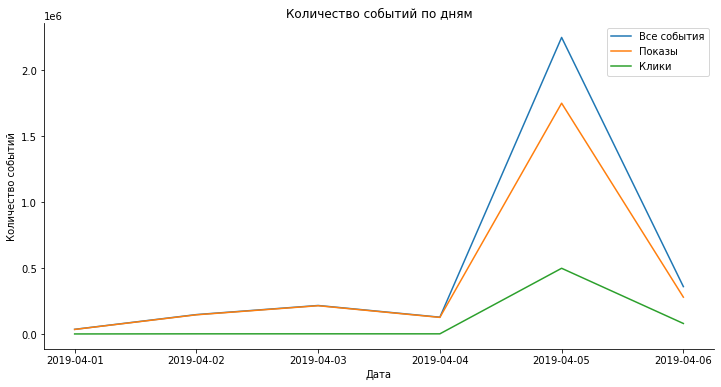

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=ads_data.groupby('date').agg({'ad_id':'count'}).ad_id, label="Все события")
sns.lineplot(data=ads_to_days.view, label="Показы")
sns.lineplot(data=ads_to_days.click, label="Клики")


plt.title('Количество событий по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий')

sns.despine()

Видим, что 5 апреля всплеск произошел и в кликах, и в показах, нужно разобраться - по всем объявлениям или какому-то конкретному:

In [14]:
ads_data[ads_data.date == '2019-04-05']\
                .groupby('ad_id')\
                .agg({'time':'count'})\
                .sort_values('time', ascending=False)\
                .head(5)

,time
ad_id,
112583,2129440
29927,27180
44635,8267
46583,7327
44956,5656


Подозрительно много событий у объявления 112583, посмотрим когда и сколько раз оно демонстрировалось

In [15]:
ads_data.query('ad_id==112583')\
        .groupby(['date', 'ad_id'])\
        .agg({'time':'count'})\
        .rename(columns={'time':'events_number'})

,,events_number
date,ad_id,
2019-04-05,112583,2129440
2019-04-06,112583,343390


Данное объявление показывалось всего два дня, и 5 апреля имело очень большой успех, будем разбиратьтся дальше.
Посмотрим на статистику по платформам.

In [16]:
max_event = ads_data.query('ad_id==112583')\
        .groupby('platform')\
        .agg({'time':'count'})
max_event['per'] = round((max_event.time/max_event.time.sum()), 2)
max_event

,time,per
platform,,
android,1229813,0.5
ios,744587,0.3
web,498430,0.2


Проверим сохраняется ли такое соотношение платформ для всех данных

In [17]:
df = ads_data.groupby('platform', as_index=False)\
        .agg({'ad_id':'count'})\
        .sort_values('ad_id', ascending=False)
df['per'] = round((df.ad_id/df.ad_id.sum()), 2)
df

,platform,ad_id,per
0,android,1560239,0.5
1,ios,942912,0.3
2,web,630952,0.2


Соотношение платформ в исходном df точно такое же, значит, дело не в платформе.
Посмотрим на динамику событий по данному объявлению по часам.

In [18]:
max_ad = ads_data.query('ad_id==112583').sort_values('date', ascending=False)
max_ad['hour'] = max_ad.full_date.dt.hour
max_ad_hour = max_ad.groupby(['date','hour']).agg({'event':'count'}).reset_index().set_index('date')
max_ad_hour

,hour,event
date,,
2019-04-05,0,43249
2019-04-05,1,25643
2019-04-05,2,38315
2019-04-05,3,18118
2019-04-05,4,23483
2019-04-05,5,44363
2019-04-05,6,59061
2019-04-05,7,101118
2019-04-05,8,123706


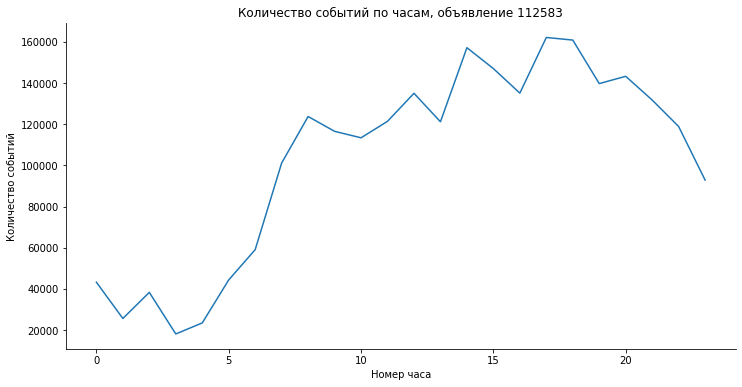

In [19]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=max_ad_hour.hour, y=max_ad_hour.event)

plt.title('Количество событий по часам, объявление 112583')
plt.xlabel('Номер часа')
plt.ylabel('Количество событий')

sns.despine()

Как видим, 6-го апреля объявление демонстрировалось в течении всего трех часов, поэтому количество событий 06.04 значительно ниже, чем 05.04. На графике закономерно видна более высокая активность в дневные часы и спад в ночные.

Возможно, данное объявление таргетировано на очень большое количество пользователй, посмотрим аудиторию и общее количество событий по этому объявлению.

In [20]:
ads_data.query('ad_id==112583').ad_cost.unique()

array([199.4])

In [21]:
ads_data.query('ad_id!=112583').ad_cost.describe()

count    661273.000000
mean        176.785565
std          50.453228
min          42.400000
25%         187.300000
50%         191.300000
75%         202.600000
max         225.400000
Name: ad_cost, dtype: float64

Как видим цена чуть выше средней, значит, дело не в этом.

Возможно, данное объявление таргетировано на очень большое количество пользователй, посмотрим аудиторию и сопоставим с общим количеством событий по этому объявлению.

In [22]:
ads_data.query('ad_id==112583').target_audience_count.unique()

array([239408])

In [23]:
ads_data.query('ad_id!=112583').target_audience_count.describe()

count    6.612730e+05
mean     3.103973e+06
std      1.320557e+07
min      1.860000e+02
25%      8.007400e+04
50%      2.514710e+05
75%      3.936013e+06
max      1.549714e+08
Name: target_audience_count, dtype: float64

Аудитория объявления небольшая 239 тысяч пользвателей, что ощутимо меньше средней аудитории для объявлений из данного датасета.

In [24]:
# суммарное количесвто событий объявления
ads_data.query('ad_id==112583').event.count()

2472830

In [25]:
# количество кликов и просмотров
ads_data.query('ad_id==112583').groupby('event').agg({'time':'count'})

,time
event,
click,576797
view,1896033


In [26]:
ads_data.query('ad_id==112583').user_id.nunique()

5323

При общем количестве событий больее 2 млн., количество уникальных пользоватлей, видевших это объявление всего 5323

In [27]:
ads_data.query('ad_id==112583').groupby('user_id').agg({'event':'count'}).describe()

,event
count,5323.000000
mean,464.555702
std,262.633466
min,61.000000
25%,93.000000
50%,604.000000
75%,668.000000
max,763.000000


То есть в среднем за сутки один пользователь взаимодействовал с нашим объявлением 464 раза (>19 раз в час)! 

Похоже, есть проблемы в логировании данных.

Попробуем найти ответ на этот впрос при дальнейшем исследовании датасета.

[Вернуться к оглавлению](#step0)

### <a id="step3">3.  Найти топ 10 объявлений по CTR за все время.</a>
Различается ли средний и медианный CTR объявлений в наших данных?

In [28]:
ads = ads_data.groupby(['ad_id', 'event'], as_index=False)\
        .agg({'time':'count'})\
        .pivot(index='ad_id', columns='event', values='time')\
        .reset_index()

In [29]:
ads = ads.assign(ctr = ads.click / ads.view,
                ctr_per = ads.click / ads.view *100)

In [30]:
ads.sort_values('ctr', ascending=False).head(10)

event,ad_id,click,view,ctr,ctr_per
289,112583,576797.0,1896033.0,0.304213,30.421253
324,119450,258.0,1254.0,0.205742,20.574163
125,38575,43.0,257.0,0.167315,16.731518
144,40968,29.0,217.0,0.133641,13.364055
207,45642,42.0,344.0,0.122093,12.209302
283,110924,11.0,95.0,0.115789,11.578947
194,45043,28.0,245.0,0.114286,11.428571
96,35034,112.0,997.0,0.112337,11.233701
5,4585,53.0,476.0,0.111345,11.134454
328,120347,236.0,2168.0,0.108856,10.885609


Здесь заметно, что аномальное объявление (id=112583) имеет так же аномально высокий CTR.

In [31]:
ads.ctr.mean()

0.020642023130966802

In [32]:
ads.ctr.median()

0.010753240746688594

<Figure size 864x432 with 0 Axes>

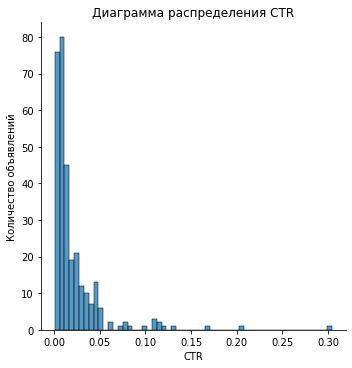

In [33]:
plt.figure(figsize=(12, 6))

sns.displot(ads.ctr, kde=False)

plt.title('Диаграмма распределения CTR')
plt.xlabel('CTR')
plt.ylabel('Количество объявлений')

sns.despine()

Медианный и средний CTR различаются почти в два раза ввиду сильно скошенного характера распределения.

[Вернуться к оглавлению](#step0)

### <a id="step4">4. Похоже, в наших логах есть баг,</a>
объявления приходят с кликами, но без показов! Сколько таких объявлений, есть ли какие-то закономерности? Эта проблема наблюдается на всех платформах?

In [34]:
ads.head(10)

event,ad_id,click,view,ctr,ctr_per
0,3,9.0,490.0,0.018367,1.836735
1,2132,1.0,95.0,0.010526,1.052632
2,2276,2.0,1454.0,0.001376,0.137552
3,2475,NaN,132.0,NaN,NaN
4,2643,3.0,286.0,0.010490,1.048951
5,4585,53.0,476.0,0.111345,11.134454
6,4877,5.0,2160.0,0.002315,0.231481
7,5028,14.0,569.0,0.024605,2.460457
8,7518,10.0,426.0,0.023474,2.347418
9,9071,7.0,441.0,0.015873,1.587302


Заметно, что в данных есть пропуски, для дальнейших рассчетов заменим их на 0.

In [35]:
ads = ads.fillna(0)

Проверим, есть ли в наших данных объявления, у которых нет ни показов, ни кликов

In [36]:
ads.query('click == 0 and view == 0')

event,ad_id,click,view,ctr,ctr_per


Таких объявлений не нашлось, а значит есть вероятность, что произошла ошибка при записи данных, посмотрим на объявления, у которых есть клики, но нет просмотров

In [37]:
ads.query('view == 0')

event,ad_id,click,view,ctr,ctr_per
50,25665,14.0,0.0,0.0,0.0
77,30381,77.0,0.0,0.0,0.0
150,41424,2.0,0.0,0.0,0.0
161,42241,126.0,0.0,0.0,0.0
213,45866,21.0,0.0,0.0,0.0
219,46363,7.0,0.0,0.0,0.0
224,46544,14.0,0.0,0.0,0.0
294,113348,16.0,0.0,0.0,0.0
331,120444,9.0,0.0,0.0,0.0


Проверим, есть ли в этом спсике аномальное объявление (id=112583)

In [38]:
ads_id_bug = ads.query('view == 0').ad_id

In [39]:
'112583' in ads_id_bug

False

Проверим, на всех ли платформах наблюдается данная проблема

In [40]:
(ads_data[ads_data.ad_id.isin(ads_id_bug)]
        .groupby('platform', as_index=False)
        .agg({'ad_id':'count'})
        .sort_values('ad_id', ascending=False))

,platform,ad_id
0,android,141
1,ios,92
2,web,53


На первый взгляд проблема чаще встречается на android, но как мы ваяснили выше, данное (5:3:2) распределение характерно для всего объема наших данных.

Проверим, есть ли такие объявления, по которым сначала произошел клик, а только потом показ:

In [41]:
ads_bags = (ads_data.groupby(['ad_id', 'event'], as_index=False)
                    .agg({'time':'min'})
                    .pivot(index='ad_id', columns='event', values='time')
                    .reset_index()
                    .query('click < view'))
ads_bags

event,ad_id,click,view
27,16548,1.554336e+09,1.554336e+09
81,30939,1.554165e+09,1.554173e+09
138,40464,1.554164e+09,1.554164e+09
158,42007,1.554423e+09,1.554423e+09
185,44543,1.554336e+09,1.554337e+09
201,45436,1.554336e+09,1.554336e+09
324,119450,1.554336e+09,1.554336e+09


Дополним ими спсиок проблемных объявлений для дальнейшей отладки логирования.

In [42]:
ads_id_bug = ads_id_bug.append(ads_bags.ad_id)

[Вернуться к оглавлению](#step0)

### <a id="step5">5. Есть ли различия в CTR</a>
у объявлений с видео и без?

In [43]:
ads_video = ads_data.merge(ads, on='ad_id')

In [44]:
ads_video.groupby('has_video').agg({'ctr':['mean', 'median']})

ctr          
               mean    median
has_video                    
0          0.242809  0.304213
1          0.002666  0.001718

Как видим, значения CTR у объявлений без видео кратно превышает аналогичное значение у объявлений с видео.

[Вернуться к оглавлению](#step0)

### <a id="step6">6. Для финансового отчета</a>
нужно рассчитать наш заработок по дням. В какой день мы заработали больше всего? В какой меньше?

Рассчитаем стоимость CPC объявлений по дням:

In [45]:
cpc = (ads_data[(ads_data.ad_cost_type == 'CPC') & (ads_data.event == 'click')]
       .groupby('date')
       .agg({'ad_cost':'sum'})
       .rename(columns={'ad_cost':'cpc_cost'}))
cpc

,cpc_cost
date,
2019-04-01,7036.9
2019-04-02,7663.7
2019-04-03,38597.2
2019-04-04,26878.0
2019-04-05,4381.2
2019-04-06,253.0


Рассчитаем стоимость CPM объявлений по дням:

In [46]:
cpm = (ads_data[(ads_data.ad_cost_type == 'CPM') & (ads_data.event == 'view')]
               .groupby('date')
               .agg({'ad_cost':'sum'})
               .rename(columns={'ad_cost':'cpm_cost'}))
cpm['cpm_cost'] = round(cpm['cpm_cost']/1000, 2)
cpm

,cpm_cost
date,
2019-04-01,6121.65
2019-04-02,26171.55
2019-04-03,34584.17
2019-04-04,19410.50
2019-04-05,347411.30
2019-04-06,55624.63


Рассчитаем суммарную прибыль по обоим типам объявлений:

In [47]:
profit = cpc.merge(cpm, on='date')
profit['full'] = profit.cpc_cost + profit.cpm_cost
profit.sort_values('full', ascending=False)

,cpc_cost,cpm_cost,full
date,,,
2019-04-05,4381.2,347411.30,351792.50
2019-04-03,38597.2,34584.17,73181.37
2019-04-06,253.0,55624.63,55877.63
2019-04-04,26878.0,19410.50,46288.50
2019-04-02,7663.7,26171.55,33835.25
2019-04-01,7036.9,6121.65,13158.55


Наибольшая прибыль получена 05.04.2019, наименьшая 01.04.2019

[Вернуться к оглавлению](#step0)

### <a id="step7">7. С помощью данных по рекламным клиентам,</a>

рассчитать конверсию из создания рекламного кабинета в запуск первой рекламы в течение года, разделить на сегменты в зависимости от этого временного промежутка.

Список промежутков – [0, 30, 90, 180, 365]

In [48]:
ads_clients_data = pd.read_csv('ads_clients_data.csv')
ads_clients_data

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08
...,...,...,...,...
122073,2020-05-07,122074,-130470790,2018-12-21
122074,2020-05-07,122075,-130911261,2018-11-09
122075,2020-05-07,122076,-130494912,2018-10-27
122076,2020-05-07,122077,-130910585,2018-12-05


In [49]:
ads_clients_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122078 entries, 0 to 122077
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   date             122078 non-null  object
 1   client_union_id  122078 non-null  int64 
 2   community_id     122078 non-null  int64 
 3   create_date      122078 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.7+ MB


In [50]:
full = ads_data.merge(ads_clients_data.drop(columns=['date', 'community_id']))

In [51]:
full[['date', 'time', 'create_date']] = full[['date', 'time', 'create_date']].apply(pd.to_datetime)

In [52]:
full.dtypes

ad_id                             int64
time                     datetime64[ns]
event                            object
date                     datetime64[ns]
ad_cost_type                     object
has_video                         int64
client_union_id                   int64
campaign_union_id                 int64
platform                         object
ad_cost                         float64
target_audience_count             int64
user_id                           int64
full_date                datetime64[ns]
create_date              datetime64[ns]
dtype: object

In [55]:
full['diff'] = full.date - full.create_date

Рассчитаем конверсию из создания рекламного кабинета в запуск первой рекламы в течение года.

In [56]:
year = pd.Timedelta(365, unit='day')
conv = round((full.query("diff < @year")
                  .client_union_id
                  .nunique()
                  /ads_clients_data
                  .client_union_id
                  .nunique()*100),2)
conv

0.27

Разобъем клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления [0, 30, 90, 180, 365].

In [57]:
full['diff_categor'] = (pd.cut(full['diff'], 
                               pd.to_timedelta(['0d', '30d', '90d', '180d', '365d']), 
                               labels=['less than 1 month', '1-3 month', '3-6 month', 'more than 6 month']))

In [58]:
categor_group = (full.groupby('diff_categor', as_index=False)
                    .agg({'client_union_id':'nunique'})
                    .sort_values('client_union_id'))
categor_group         

,diff_categor,client_union_id
0,less than 1 month,7
3,more than 6 month,62
1,1-3 month,103
2,3-6 month,168


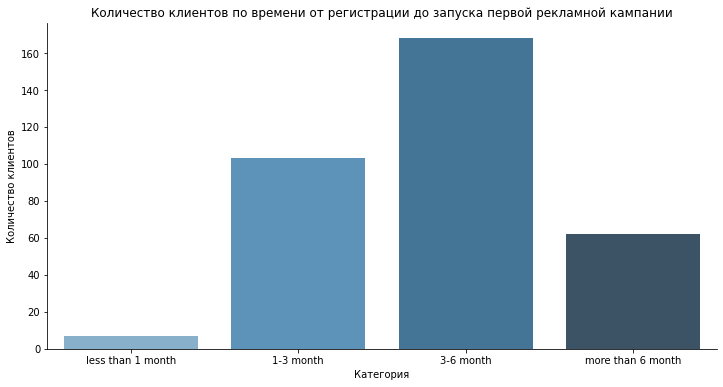

In [59]:
plt.figure(figsize=(12, 6))

sns.barplot(y='client_union_id', x='diff_categor', data=categor_group, palette="Blues_d" )

plt.title('Количество клиентов по времени от регистрации до запуска первой рекламной кампании')
plt.xlabel('Категория')
plt.ylabel('Количество клиентов')

sns.despine()

Самая многочисленная группа - клиенты, запускающие рекламную кампанию в течении 3-6 месяцев после регистрации.

Выявлено много проблем в данных:
- более 40 000 дубликатов,
- объявления с кликами, но без показов,
- объявления, по которым клик произошел раньше показа,
- неадекватно высокая активность по объявлению id=112583, более 2 млн. событий за стуки на 5323 пользователей.

Налицо проблема в записи данных, необходимо сообщить эту информацию коллегам для отладки логирования.

[Вернуться к оглавлению](#step0)